<a href="https://colab.research.google.com/github/DestonSJU/AgenticAI/blob/main/Agentic_AI_Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# //*** Deston Willis
# //*** Generative/Agentic AI
# //*** 1/28/26
# //*** Assignment 1: The purpose of this assignment is to test the GPT-2 model and how changing temperature affects the response of the model

In [ ]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 7.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT


In [ ]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: I like pizza. My favorite topping is


In [ ]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


Token IDs: [40, 588, 14256, 13, 2011, 4004, 34366, 318]
Tokens:
    40 → 'I'
   588 → ' like'
 14256 → ' pizza'
    13 → '.'
  2011 → ' My'
  4004 → ' favorite'
 34366 → ' topping'
   318 → ' is'


In [ ]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([1, 8, 768])


In [ ]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)


Hidden state shape: torch.Size([1, 8, 768])


In [ ]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)


Logits shape: torch.Size([1, 50257])


In [ ]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


Top 10 next-token probabilities:
      ' the' : 0.2535
       ' to' : 0.0949
        ' a' : 0.0869
    ' pizza' : 0.0788
     ' that' : 0.0511
       ' my' : 0.0305
         ',' : 0.0188
        ' "' : 0.0188
      ' not' : 0.0089
       ' in' : 0.0080


In [ ]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=2.0, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))


Sampled token:  good


# Homework 1 Analysis

## Results:

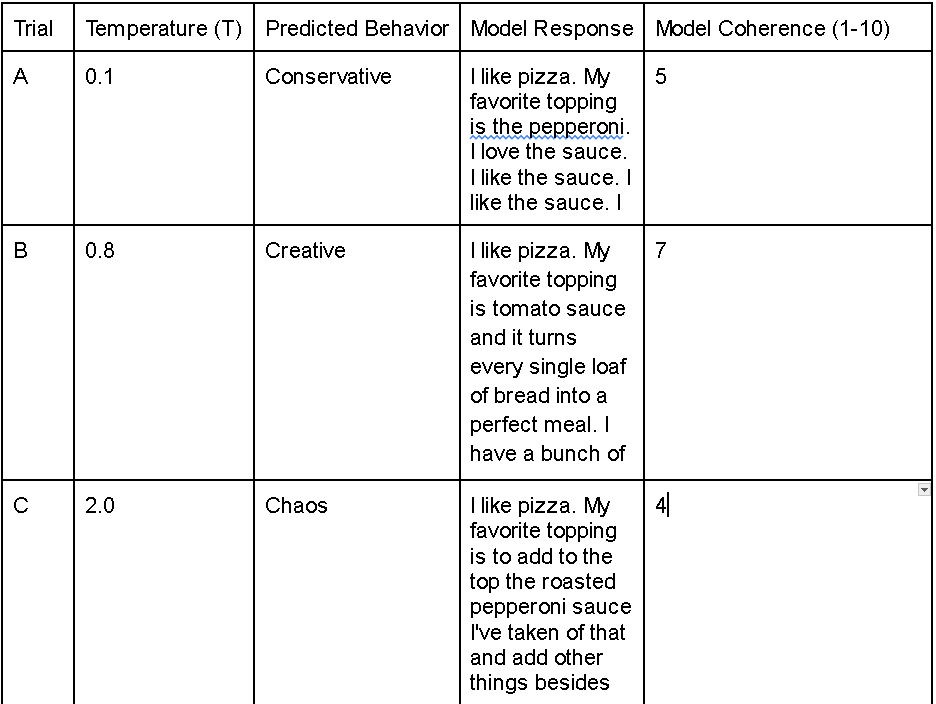

I tested the GPT-2 model by recording the responses it generated with temperatures 0.1, 0.8, and 2.0 with the following prompt: "I like pizza. My favorite topping is". I gave the Conservative response a score of 5. While it gives a correct topping of pepperoni, after thaat it repeats itself saying "I love/like the sauce" for the rest of the response. This makes sense since the lower temperature would mean that the model would stick to the token that is most likely more often instead of sometimes using one with a lower probability. The Creative response was the best oit of the 3 with a score of 7 but it wasn't perfect. The main issue was that it starts talking about a loaf of bread. While bread is loosely related to pizza, it is off topic. Other than that, for the most part the response is good. Lastly, I gave the Chaotic response a score of 4. While it does bring up pepperoni, it uses a lot of unnecessary words to get there. As well, after that, it starts talking about nonsense.

Overall, the main time that the model repeated words was the Conservative response. After it listed a topping, it repeated more or less the same sentence over and over for the rest of the response. While some of what the model came up with was nonsense or didn't make complete sense, it used real words throughout and didn't use any random characters or punctuation. If this were to be the case, it would happen more frequently with a higher temperature. This is because when the temperature is higher, the probabilities become more equalized where the model will pick tokens with lower probabilities more often. If temperature is extremly high (infinite), probabilities will  become equal where each option will be just as likely. This is what can lead to the model choosing nonsense in its response since those responses are just as likely as the ones that do make sense when the temperature is very high. If I were to build a medical AI then I would use a very low temperature since I would want the model to choose the answer that is most likely rather than sometimes picking less likely ones since a wrong answer could be very problematic. If I building an AI to write a dream journal I would pick a temperature somewhere around or slightly above 1 since I would want the model to pick some options that are less likely sometimes so that it can be creative instead of only picking the most likely response.

In [ ]:
# Full loop (generate multiple tokens)
# Temperature is changed between 0.1, 0.8, and 2.0. As well the steps were changed to 20

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=2.0, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=20)


I like pizza. My favorite topping is to
I like pizza. My favorite topping is to add
I like pizza. My favorite topping is to add to
I like pizza. My favorite topping is to add to the
I like pizza. My favorite topping is to add to the top
I like pizza. My favorite topping is to add to the top the
I like pizza. My favorite topping is to add to the top the roasted
I like pizza. My favorite topping is to add to the top the roasted pepper
I like pizza. My favorite topping is to add to the top the roasted pepperoni
I like pizza. My favorite topping is to add to the top the roasted pepperoni sauce
I like pizza. My favorite topping is to add to the top the roasted pepperoni sauce I
I like pizza. My favorite topping is to add to the top the roasted pepperoni sauce I've
I like pizza. My favorite topping is to add to the top the roasted pepperoni sauce I've taken
I like pizza. My favorite topping is to add to the top the roasted pepperoni sauce I've taken of
I like pizza. My favorite topping is to

# Extra Credit

In [ ]:
# Load tokenizer & model
# Distilled GPT-2 is used instead of regular GPT-2

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: I like pizza. My favorite topping is


In [ ]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


Token IDs: [40, 588, 14256, 13, 2011, 4004, 34366, 318]
Tokens:
    40 → 'I'
   588 → ' like'
 14256 → ' pizza'
    13 → '.'
  2011 → ' My'
  4004 → ' favorite'
 34366 → ' topping'
   318 → ' is'


In [ ]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([1, 8, 768])


In [ ]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)

Hidden state shape: torch.Size([1, 8, 768])


In [ ]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)

Logits shape: torch.Size([1, 50257])


In [ ]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


Top 10 next-token probabilities:
      ' the' : 0.1109
        ' a' : 0.0482
    ' pizza' : 0.0278
       ' my' : 0.0262
     ' this' : 0.0114
   ' cheese' : 0.0075
   ' tomato' : 0.0075
         ':' : 0.0074
     ' from' : 0.0071
    ' lemon' : 0.0071


In [ ]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=2.0, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))


Sampled token:  cream


## Results: GPT-2 vs Distilled GPT-2
## GPT-2
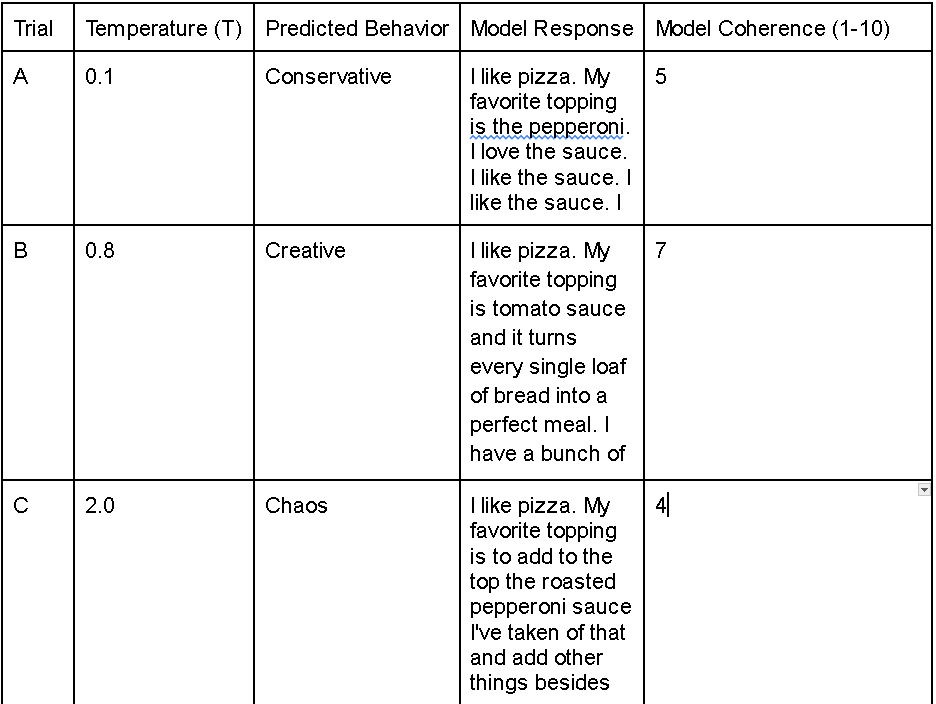

## Distilled GPT-2
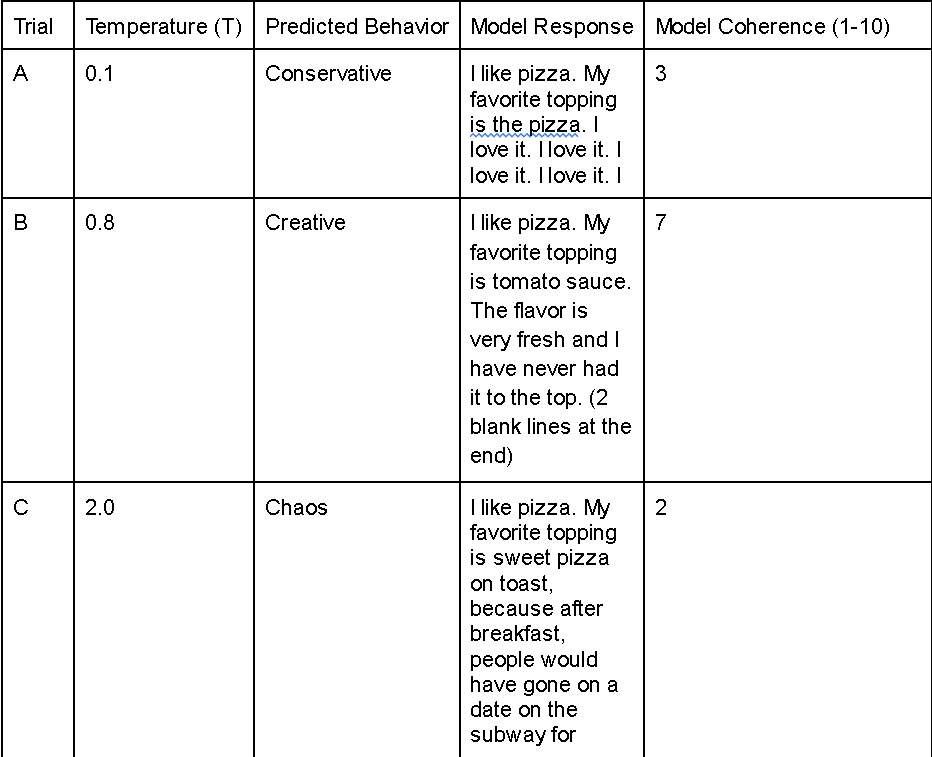

Comparing the responses of the 2 models, while they are similar in a lot of ways, but the gpt-2 model produced slightly better responses as a whole than the distilled model. The Conservatice response of the distilled model got a 3 compared to 5 for the regular one. Both of them have the problem of repetition at the end but the regular model at least switched from like to love in its repetion while the distilled one repeated the exact same sentence each time. The biggest difference was that the regular model gave an actual topping (pepperoni) while the distilled model just gave pizza as the favorite topping, which doesn't make sense. The Creative responses for the 2 models were very similar in quality, with them both receiving a score of 7. The distilled model starts out very strong but the wording choice at the end doesn't make sense. As well, there are 2 empty lines at the end that it chooses to add for some reason. I found these problems to be about equal to the ones that the regular Creative response had (going off topic), which is why I gave them the same score. Both of the Chaotic responses were pretty bad, with the distilled model getting a 2 and the regular model getting a 4. This is because both of these sentences are mostly nonsense. While the regular model at least mentioned a topping in its response, the distilled model doesn't even mention an actual topping at all, which is why it got a lower score.

In [ ]:
# Full loop (generate multiple tokens)
# Temperature is changed between 0.1, 0.8, and 2.0. As well the steps were changed to 20

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=2.0, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=20)

I like pizza. My favorite topping is sweet
I like pizza. My favorite topping is sweet pizza
I like pizza. My favorite topping is sweet pizza on
I like pizza. My favorite topping is sweet pizza on toast
I like pizza. My favorite topping is sweet pizza on toast,
I like pizza. My favorite topping is sweet pizza on toast, because
I like pizza. My favorite topping is sweet pizza on toast, because after
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast,
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast, people
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast, people would
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast, people would have
I like pizza. My favorite topping is sweet pizza on toast, because after breakfast, people would have gone
I like pizza. My favorite topping i